# Quantum GAN com Pennylane e MedMNIST

Este notebook apresenta uma implementação simplificada de uma GAN quântica inspirada no método de *patches* descrito por Huang et al. Utilizamos o dataset **MedMNIST** para comparação com os modelos clássicos.

## 1. Setup Quântico
Instalação de `pennylane` e demais bibliotecas necessárias para execução do modelo híbrido.

In [1]:
!pip install pennylane pennylane-lightning torch medmnist matplotlib --quiet
import torch
import pennylane as qml
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt

## 2. Preparação do Dataset
Utilizamos o mesmo subset do notebook clássico para permitir comparação direta. Pode ser necessário reduzir a resolução das imagens para se adequar ao número de qubits disponíveis.

In [2]:
# Seleciona o dataset
DATA_FLAG = 'breastmnist'
info = INFO[DATA_FLAG]
download = True

transform = transforms.Compose([
    #transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Carrega treino e teste
train_dataset = getattr(medmnist, info['python_class'])(split='train', transform=transform, download=download)
test_dataset = getattr(medmnist, info['python_class'])(split='test', transform=transform, download=download)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz


In [3]:
print(train_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /home/mahlow/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0


## 4. Treinamento
Configuração de modelos e funções para treinamento separado por classes.

In [4]:
import os
import math
import time

import numpy as np
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# ——— Hiperparâmetros ———
image_size    = 5      # tamanho do “patch”
batch_size    = 8      # tamanho do batch
pca_dims      = 40     # dimensão final (8 geradores × 5 qubits)
n_qubits      = 5      # número de qubits (e de features por gerador)
q_depth       = 6      # profundidade do circuito
n_generators  = 8      # quantos “patches” quânticos → 40 dims

# ——— Dispositivo GPU ———
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.empty_cache()

# ——— Função de escala para PCA ———
def scale_data(data, scale=None, dtype=np.float32):
    if scale is None:
        scale = [-1, 1]
    mn, mx = float(np.min(data)), float(np.max(data))
    a, b   = float(scale[0]), float(scale[1])
    return (((b - a) * (data - mn) / (mx - mn)) + a).astype(dtype)

# ——— Pré-processamento (PCA) ———
all_imgs   = train_dataset.imgs if hasattr(train_dataset, "imgs") else train_dataset.data
flat_imgs  = all_imgs.reshape(len(all_imgs), -1)
scaled     = scale_data(flat_imgs, [0, 1])
pca        = PCA(n_components=pca_dims)
pca_data   = pca.fit_transform(scaled)

# ——— Circuito quântico ———
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):
    weights = weights.reshape(q_depth, n_qubits)
    # codifica ruído
    for q in range(n_qubits):
        qml.RY(noise[q], wires=q)
        qml.RX(noise[q], wires=q)
    # camadas variacionais + emaranhamento
    for layer in range(q_depth):
        for q in range(n_qubits):
            qml.RY(weights[layer][q], wires=q)
        for q in range(n_qubits - 1):
            qml.CZ(wires=[q, q + 1])
    # retorna valor esperado de X em cada qubit
    return [qml.expval(qml.PauliX(q)) for q in range(n_qubits)]

# ——— Modelos ———
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(pca_dims,        hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,      hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.model(x)

class QuantumGenerator(nn.Module):
    def __init__(self, n_generators, q_delta=1.0):
        super().__init__()
        # mantenha os parâmetros quânticos em CPU, pois o simulação roda em CPU
        self.q_params = nn.ParameterList([
            nn.Parameter(q_delta * torch.rand(q_depth, n_qubits), requires_grad=True)
            for _ in range(n_generators)
        ])
        self.n_generators = n_generators

    def forward(self, x):
        batch_size = x.size(0)
        # saída final: batch_size × (n_generators * n_qubits) = batch_size × 40
        images = torch.zeros(batch_size, self.n_generators * n_qubits, device=device)

        for gen_idx, params in enumerate(self.q_params):
            # para cada amostra, roda o circuito (em CPU) e retorna CPU tensor
            patches = torch.stack([
                torch.tensor(
                    quantum_circuit(sample.cpu(), params.cpu()),
                    device=device
                ).float()
                for sample in x
            ], dim=0)  # shape (batch_size, n_qubits)

            start = gen_idx * n_qubits
            images[:, start:start + n_qubits] = patches

        return images



### 4.1 Treinamento separado por classe
Treinamos dois geradores: um para imagens malignas (rótulo 0) e outro para imagens benignas (rótulo 1).

In [5]:
def train_quantum_gan(loader, G, D, epochs=50, device=None):
    """
    Treina o Quantum GAN usando dados de PCA vindos de `loader` (CPU, pin_memory=True)
    G e D já devem estar instanciados e enviados corretamente ao device.
    Retorna listas de histórico de loss do Discriminador e do Gerador.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = nn.BCELoss()
    optD = optim.SGD(D.parameters(), lr=1e-2)
    optG = optim.SGD(G.parameters(), lr=3e-1)
    hist_D, hist_G = [], []

    total_start = time.time()
    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        running_D, running_G = 0.0, 0.0

        for real in loader:
            # real sai do DataLoader como tensor CPU pinned
            real = real.to(device, non_blocking=True)  # move para GPU
            b_size = real.size(0)

            # rótulos
            real_label = torch.ones((b_size, 1), device=device)
            fake_label = torch.zeros((b_size, 1), device=device)

            # gera amostras falsas
            noise = torch.rand(b_size, n_qubits, device=device) * (math.pi / 2)
            fake = G(noise)

            # --- Atualiza Discriminador ---
            optD.zero_grad()
            out_real = D(real)
            out_fake = D(fake.detach())
            loss_D = criterion(out_real, real_label) + criterion(out_fake, fake_label)
            loss_D.backward()
            optD.step()

            # --- Atualiza Gerador ---
            optG.zero_grad()
            out_fake = D(fake)
            loss_G = criterion(out_fake, real_label)
            loss_G.backward()
            optG.step()

            running_D += loss_D.item()
            running_G += loss_G.item()

        # calcula médias por batch
        hist_D.append(running_D / len(loader))
        hist_G.append(running_G / len(loader))
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch}/{epochs}: D={hist_D[-1]:.4f}, G={hist_G[-1]:.4f} — {epoch_time:.2f}s")

    total_time = time.time() - total_start
    print(f"Training completed in {total_time:.2f}s")
    return hist_D, hist_G

# Exemplo de uso:


In [ ]:
from torch.utils.data import DataLoader

# ——— Cria DataLoaders PCA por rótulo ———
# Extrai labels originais (pode ser .labels ou .targets)
labels = train_dataset.labels if hasattr(train_dataset, "labels") else train_dataset.targets

# Escala e converte o PCA já treinado (pca_data) para Tensor CPU
scaled_pca_np = scale_data(pca_data)                            # shape (N, 40)
tensor_pca     = torch.from_numpy(scaled_pca_np).float()        # Tensor CPU

# Índices para cada classe
idx0 = [i for i, l in enumerate(labels) if int(l) == 0]
idx1 = [i for i, l in enumerate(labels) if int(l) == 1]

# Subconjuntos PCA por rótulo
pca0 = tensor_pca[idx0]   # amostras “malignas”
pca1 = tensor_pca[idx1]   # amostras “benignas”

# DataLoaders com pin_memory para transferir rapidamente à GPU
loader_mal = DataLoader(pca0, batch_size=batch_size, shuffle=True,  drop_last=True, pin_memory=True)
loader_ben = DataLoader(pca1, batch_size=batch_size, shuffle=True,  drop_last=True, pin_memory=True)

# ——— Treina dois QGANs, um para cada classe ———
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Maligno (label 0)
G_mal = QuantumGenerator(n_generators).to(device)
D_mal = Discriminator().to(device)
hist_D_mal, hist_G_mal = train_quantum_gan(loader_mal, G_mal, D_mal, epochs=50, device=device)

# Benigno (label 1)
G_ben = QuantumGenerator(n_generators).to(device)
D_ben = Discriminator().to(device)
hist_D_ben, hist_G_ben = train_quantum_gan(loader_ben, G_ben, D_ben, epochs=50, device=device)


/tmp/ipykernel_1207031/383101395.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx0 = [i for i, l in enumerate(labels) if int(l) == 0]
/tmp/ipykernel_1207031/383101395.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx1 = [i for i, l in enumerate(labels) if int(l) == 1]


Epoch 1/50: D=1.3853, G=0.7454 — 15.30s
Epoch 2/50: D=1.3773, G=0.7438 — 14.31s
Epoch 3/50: D=1.3699, G=0.7438 — 14.30s
Epoch 4/50: D=1.3611, G=0.7459 — 14.32s


### Curvas de Loss

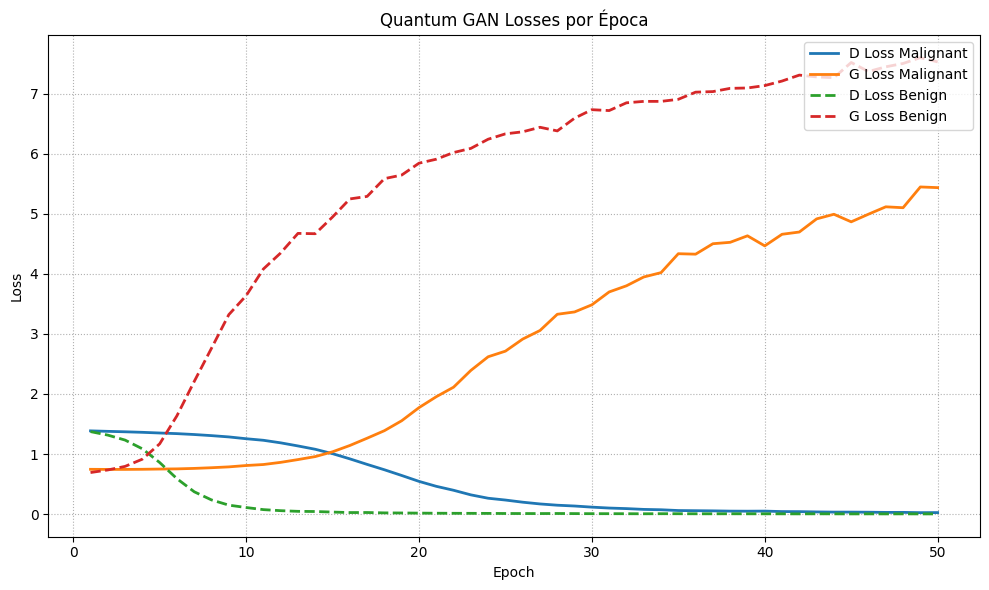

In [12]:
import matplotlib.pyplot as plt

# use “hist” porque é assim que você nomeou as listas retornadas
epochs = list(range(1, len(hist_D_mal) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, hist_D_mal, label='D Loss Malignant',     linewidth=2)
plt.plot(epochs, hist_G_mal, label='G Loss Malignant',     linewidth=2)
plt.plot(epochs, hist_D_ben, label='D Loss Benign',  linestyle='--', linewidth=2)
plt.plot(epochs, hist_G_ben, label='G Loss Benign',  linestyle='--', linewidth=2)

plt.title('Quantum GAN Losses por Época')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle=':')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## 5. Avaliação
Utilize as mesmas métricas (FID e IS) para comparar as imagens geradas pela abordagem quântica.

In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import pandas as pd

def evaluate_gan(
    G,
    label_target: int,
    gan_name: str,
    gen_label_name: str,
    test_dataset,
    n_qubits: int,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    max_batches: float = float('inf')
):
    """
    Avalia um gerador GAN usando FID e Inception Score.
    
    Correções aplicadas:
      - usa normalize=True tanto em FID quanto em InceptionScore, para aceitar tensores float em [0,1].
      - converte imagens grayscale (1 canal) em RGB (3 canais).
      - redimensiona tudo para 299×299 (requisito do InceptionV3).
    """
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # normalize=True: aceita floats em [0,1] e faz o cast interno para uint8
    fid = FrechetInceptionDistance(feature=64, normalize=True).to(device)
    is_metric = InceptionScore(normalize=True).to(device)
    
    G = G.to(device)
    G.eval()
    
    count = 0
    for real, labels in loader:
        mask = (labels.squeeze() == label_target)
        if mask.sum() == 0:
            continue
        
        # real: [B,1,H,W], floats em [0,1]
        real = real[mask].to(device)
        real = real.repeat(1, 3, 1, 1)  # -> [B,3,H,W]
        real = F.interpolate(real, size=(299, 299), mode='bilinear', align_corners=False)
        
        b_size = real.size(0)
        noise = torch.rand(b_size, n_qubits, device=device) * (torch.pi / 2)
        
        with torch.no_grad():
            fake = G(noise)  # supõe saída [B,1,H,W], floats em [0,1]
        fake = fake.to(device)
        fake = fake.repeat(1, 3, 1, 1)  # -> [B,3,H,W]
        fake = F.interpolate(fake, size=(299, 299), mode='bilinear', align_corners=False)
        
        # atualiza métricas com floats em [0,1]
        fid.update(real, real=True)
        fid.update(fake, real=False)
        is_metric.update(fake)
        
        count += 1
        if count >= max_batches:
            break
    
    fid_score = fid.compute().item()
    is_mean, is_std = is_metric.compute()
    
    return {
        'GAN': gan_name,
        'Generator_Label': gen_label_name,
        'Real_Label': 'Malignant' if label_target == 0 else 'Benign',
        'FID': fid_score,
        'IS_Mean': is_mean.item(),
        'IS_Std': is_std.item()
    }

# Exemplo de uso:
results = []
results.append(evaluate_gan(G_mal, 0, 'QuantumGAN', 'Malignant', test_dataset, n_qubits))
results.append(evaluate_gan(G_ben, 1, 'QuantumGAN', 'Benign',   test_dataset, n_qubits))
results_df = pd.DataFrame(results)
results_df


/home/mahlow/anaconda3/envs/my_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


,GAN,Generator_Label,Real_Label,FID,IS_Mean,IS_Std
0,QuantumGAN,Malignant,Malignant,60.409332,1.0,0.0
1,QuantumGAN,Benign,Benign,113.803749,1.0,0.0


## Classificação com ResNet

In [14]:
from torchvision.models import resnet18
import torch.nn.functional as F
from torch.utils.data import Dataset, ConcatDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def custom_collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)
    ys_list = []
    for y in ys:
        if isinstance(y, torch.Tensor):
            val = y.item() if y.numel() == 1 else int(y.argmax().item())
        else:
            val = int(y)
        ys_list.append(val)
    ys = torch.tensor(ys_list, dtype=torch.long)
    return xs, ys

class SyntheticDataset(Dataset):
    def __init__(self, generator_dict, num_per_class, latent_dim, device=None):
        self.samples = []
        device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        for label_name, gen in generator_dict.items():
            label = 0 if label_name == 'malignant' else 1
            noise = torch.rand(num_per_class, n_qubits, device=device) * torch.pi/2
            with torch.no_grad():
                imgs = gen(noise).cpu()
            for img in imgs:
                self.samples.append((img, label))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

def train_model(model, loader, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(dim=1).cpu()
            all_preds.append(preds)
            all_labels.append(y)
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = float('nan')
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return acc, prec, rec, f1, auc, tn, fp, fn, tp

def run_experiments(train_dataset, test_dataset, G_dict, batch_size=32, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    latent_dim = n_qubits
    ratios = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5]
    results = []
    for r in ratios:
        if r == 0.0:
            ds = train_dataset
        else:
            num_syn = int(len(train_dataset) * r)
            syn_ds = SyntheticDataset(G_dict, num_syn // 2, latent_dim, device)
            ds = ConcatDataset([train_dataset, syn_ds])
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        model = resnet18(num_classes=2)
        model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        train_model(model, loader, epochs=epochs, device=device)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
        acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
        results.append({'ratio': r,'acc': acc,'prec': prec,'rec': rec,'f1': f1,'auc': auc,'tn': tn,'fp': fp,'fn': fn,'tp': tp})
    syn_only_ds = SyntheticDataset(G_dict, len(train_dataset)//2, latent_dim, device)
    syn_loader = DataLoader(syn_only_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, syn_loader, epochs=epochs, device=device)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({'ratio':'100%_sintético→real','acc':acc,'prec':prec,'rec':rec,'f1':f1,'auc':auc,'tn':tn,'fp':fp,'fn':fn,'tp':tp})
    total_syn = len(syn_only_ds)
    n_train = int(total_syn * 0.7)
    n_test = total_syn - n_train
    syn_train_ds, syn_test_ds = random_split(syn_only_ds, [n_train, n_test])
    train_loader = DataLoader(syn_train_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    test_loader = DataLoader(syn_test_ds, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, train_loader, epochs=epochs, device=device)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({'ratio':'100%_sintético_70/30_selftest','acc':acc,'prec':prec,'rec':rec,'f1':f1,'auc':auc,'tn':tn,'fp':fp,'fn':fn,'tp':tp})
    return pd.DataFrame(results)


In [15]:
G_dict = {'malignant': G_mal, 'benign': G_ben}
classification_results = run_experiments(train_dataset, test_dataset, G_dict, batch_size=64, epochs=5)
classification_results


/tmp/ipykernel_1207031/1243825210.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


RuntimeError: stack expects each tensor to be equal size, but got [1, 28, 28] at entry 0 and [40] at entry 3

In [ ]:
classification_results